In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
import cv2
import chainer
import chainer.functions as F           # パラメータを含まない関数を収録したパッケージ
import chainer.links as L               # パラメータを含む関数を収録したパッケージ
from chainer import computational_graph # グラフを出力するパッケージ
from chainer import serializers    
from chainer.datasets import tuple_dataset, TransformDataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators


In [81]:
#読み込み
train_ = pd.read_csv('train.csv/train.csv')
test_ = pd.read_csv('test.csv/test.csv')

In [82]:
#imagesにすべての画像(images21に入っている)を格納しておく
images=[]

for i in range(1, 1585):
    #%に入る
    image = cv2.imread('images2/%d.jpg'%i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(grayed)

In [83]:
#imagesの長さの確認
len(images)

1584

In [84]:
#画像データを32*32に大きさを変換するメソッド
def resize_image(img):
    end_size = 32
    max_ = np.maximum(img.shape[0], img.shape[1])
    scale = end_size / max_
    height, width = img.shape
    size = (int(width*scale), int(height*scale))

    rescale_image = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)

    height, width = rescale_image.shape

    if width > height:
        z_pad = np.zeros([int((width-height)/2), width], dtype=np.uint8)
        end_image = np.vstack((z_pad, rescale_image, z_pad))
    else:
        z_pad = np.zeros([height, int((height - width)/2)], dtype=np.uint8)
        end_image = np.hstack((z_pad, rescale_image, z_pad))

    end_image = cv2.resize(end_image, (end_size, end_size))

    return end_image


In [85]:
for i, img in enumerate(images):
    cv2.imwrite("images3/%d.jpg"%(i+1), resize_image(img))

In [86]:
#train_データのラベル
labels = train_['species']

In [87]:
#labelsの確認
labels.head()

0              Acer_Opalus
1    Pterocarya_Stenoptera
2     Quercus_Hartwissiana
3          Tilia_Tomentosa
4       Quercus_Variabilis
Name: species, dtype: object

In [88]:
#長さの確認
print(len(labels))

990


In [89]:
#32*32の画像データをtrain_データのみリストに格納する
resized_images = []
for i in train_.id:
    image = cv2.imread('images3/%d.jpg' % i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_images.append(grayed)


In [90]:
#resized_imagesの大きさを確認
print(len(resized_images))

990


In [91]:
#numpyのarrayに変換し、chainerが扱える型にしておく
resized_images = np.array([resized_images]).astype(np.float32)

In [93]:
#大きさを確認
print(resized_images.shape)

(1, 990, 32, 32)


In [94]:
#大きさを(990, 1, 32, 32)に変換
resized_images = np.reshape(resized_images, (990, 1, 32, 32))

In [95]:
#大きさが変わったことを確認
print(resized_images.shape)

(990, 1, 32, 32)


In [96]:
#labelのエンコードを行う。
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
labels = labels.astype(np.int32)

In [97]:
labels.shape

(990,)

In [122]:
#閾値を決めて、訓練用データと検証用データに分ける。
threshold = 600
train = tuple_dataset.TupleDataset(resized_images[0:threshold],labels[0:threshold])
test = tuple_dataset.TupleDataset(resized_images[threshold:],labels[threshold:])

In [126]:
#4層のMLPクラスを作る。
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 99) # out_channelはクラス数と同じ5に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

       

In [127]:
#model,optimizerの設定
model = L.Classifier(CNN())
from chainer import optimizers
optimizer = optimizers.Adam()
optimizer.setup(model)

In [128]:
batchsize = 99 #一回のバッチサイズ
n_epoch = 20 #学習の繰り返し回数

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

In [129]:
#augumention
def transform(inputs):
    x , t = inputs
    _, h, w = x.shape
    #x_offset = np.random.randint(4)
    #y_offset = np.random.randint(4)
    #x = x[y_offset:y_offset + h -4, x_offset:x_offset + w -4]
    if np.random.rand() > 0.5:
        x = np.fliplr(x)
        
    return x, t

In [130]:
from chainer.datasets import tuple_dataset, TransformDataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

train = TransformDataset(train, transform)
train_iter = iterators.SerialIterator(train,batch_size=batchsize,shuffle=True)

updater = training.StandardUpdater(train_iter,optimizer)
trainer = training.Trainer(updater,(n_epoch,'epoch'),out = 'result')

In [131]:
test = TransformDataset(test, transform)
test_iter = iterators.SerialIterator(test,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [132]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.011544       120.043     0.0102639                 20.2618               
2           0.016835       10.2751     0.0151515                 5.24532               
3           0.0353535      4.73022     0.0516455                 4.59265               
4           0.0808081      4.35142     0.0383675                 4.40176               
5           0.117845       3.94369     0.100929                  4.05323               
6           0.213805       3.366       0.123004                  3.58758               
7           0.335017       2.63256     0.223281                  2.97987               
8           0.410774       2.15976     0.289589                  2.5766                
9           0.489899       1.77049     0.306533                  2.3408                
10          0.563973       1.41176     0.335696                  2.33483               
11          0.651515       1.26335

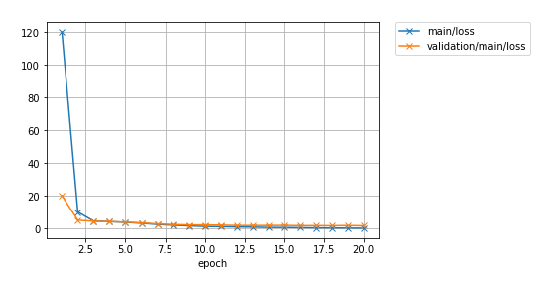

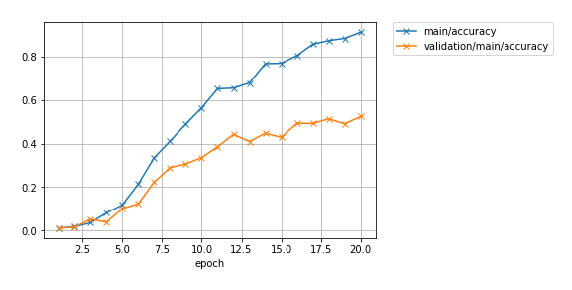

In [133]:
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()
#損失関数と精度の視覚化    
show_graph('result/loss.png')
show_graph('result/accuracy.png')

In [166]:
#modelの保存
serializers.save_npz('my_model', model)

In [167]:
#modelの読み込み
serializers.load_npz('my_model', model)

In [177]:
#提出用の画像データの読み込み
predict_images = []
for i in test_.id:
    image = cv2.imread('images3/%d.jpg' % i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    predict_images.append(grayed)
    

In [180]:
#大きさを自分が作ったCNNにあわせる
predict_images = np.array([predict_images])
predict_images = predict_images.reshape((594, 1, 32, 32))
predict_images.shape

(594, 1, 32, 32)

In [181]:
#chainerが扱える形に変換
predict_images = predict_images.astype(np.float32)

In [182]:
predict_label = []
#予測する関数
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred = model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

pred = predict(model, predict_images)

In [186]:
#得られたラベルを元のspeciesに戻す。
predic_label = le.inverse_transform(pred)
predic_label

C:\Users\falcon4842\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Quercus_Agrifolia', 'Quercus_Variabilis', 'Quercus_Ellipsoidalis',
       'Quercus_x_Hispanica', 'Quercus_Semecarpifolia', 'Acer_Rubrum',
       'Acer_Platanoids', 'Eucalyptus_Glaucescens', 'Quercus_Variabilis',
       'Acer_Rufinerve', 'Eucalyptus_Neglecta', 'Magnolia_Salicifolia',
       'Quercus_Pubescens', 'Quercus_Alnifolia', 'Quercus_Agrifolia',
       'Populus_Nigra', 'Alnus_Viridis', 'Quercus_Trojana',
       'Quercus_Brantii', 'Quercus_Palustris', 'Quercus_Crassipes',
       'Quercus_Chrysolepis', 'Eucalyptus_Neglecta',
       'Eucalyptus_Neglecta', 'Acer_Circinatum', 'Quercus_x_Turneri',
       'Eucalyptus_Glaucescens', 'Arundinaria_Simonii',
       'Liquidambar_Styraciflua', 'Quercus_Nigra', 'Quercus_Variabilis',
       'Quercus_Pontica', 'Quercus_x_Turneri', 'Alnus_Sieboldiana',
       'Acer_Saccharinum', 'Liriodendron_Tulipifera', 'Alnus_Cordata',
       'Quercus_Imbricaria', 'Liriodendron_Tulipifera',
       'Tilia_Platyphyllos', 'Acer_Rufinerve', 'Ginkgo_Biloba',

In [197]:
df_test_id = pd.DataFrame(test_.id, columns=['id'])
df_test_pred = pd.DataFrame(predic_label, columns=['species'])
#kaggleの評価は、それぞれのspeciesでの確率なのでダミー変数化しておく。0か1で確率表現ができる。
df_test_pred_dummy = pd.get_dummies(df_test_pred['species'])
df_submit = pd.concat([df_test_id, df_test_pred_dummy], axis=1)
df_submit.to_csv('leaf_classification.csv', index=False)